# Graph Network LRP - Examples

In [1]:
%matplotlib agg
import networkx as nx
import matplotlib
matplotlib.rcParams['figure.max_open_warning'] = 100
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML

import sys
import torch
import numpy as np
import torch_scatter
import torchgraphs as tg

import yaml
import pandas as pd
from pathlib import Path
from munch import munchify
from collections import OrderedDict

from infection.dataset import InfectionDataset
from infection.networks import InfectionGN
from utils import import_
import relevance
import guidedbackprop as guidedbp

def label_txt(label):
    if label in {+1., -1.}:
        return '$+$' if bool(label>0) else '$-$'   
    else:
        return '$\cdot$'

In [2]:
layout =dict(enumerate(.03 * np.array([
    [-1, 1],
    [ 1, 1],
    [ 0, 0],
    [-1,-1],
    [ 1,-1],
])))

node_size=400

def plot_in_target_out(graph_in, graph_target, graph_out, layout):
    infected = (graph_in.node_features[:,0] == 1).nonzero().view(-1).tolist()
    immune = (graph_in.node_features[:,1] == 1).nonzero().view(-1).tolist()
    others = [i for i in range(graph_in.num_nodes) if i not in infected and i not in immune]

    virtual = [list(graph_in.to_networkx().edges)[i] for i in (graph_in.edge_features[:,0] == 1).nonzero().view(-1).tolist()]
    nonvirtual = [e for e in graph_in.to_networkx().edges if e not in virtual]
    
    gs = gridspec.GridSpec(2, 3, height_ratios=[2, 1])
    fig = plt.figure(figsize=(6, 3))

    ax = fig.add_subplot(gs[0,0])
    node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
    nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=node_size, node_color='C3', pos=layout, ax=ax)
    nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=node_size, node_color='C2', pos=layout, ax=ax)
    nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=node_size, node_color='C0', pos=layout, ax=ax)
    nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, width=3., alpha=.7, arrowsize=20)
    nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax, arrowsize=20)
    nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=12, font_weight='bold', font_color='white')
    ax.set_title('Input')
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-.04, +.04)
    ax.set_ylim(-.04, +.04)
    ax.axis('off')

    ax = fig.add_subplot(gs[0,1])
    infected_target = graph_target.node_features[:,0].nonzero().view(-1).tolist()
    others_target = [i for i in range(graph_target.num_nodes) if i not in infected_target and i not in immune]
    nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected_target, node_size=node_size, node_color='C3', pos=layout, ax=ax)
    nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=node_size, node_color='C2', pos=layout, ax=ax)
    nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others_target,   node_size=node_size, node_color='C0', pos=layout, ax=ax)
    nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, width=3., alpha=.7, arrowsize=20)
    nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax, arrowsize=20)
    nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=12, font_weight='bold', font_color='white')
    ax.set_title(f'Target ({graph_target.global_features.item()})')
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-.04, +.04)
    ax.set_ylim(-.04, +.04)
    ax.axis('off')

    ax = fig.add_subplot(gs[0,2])
    predicted_colors = graph_out.node_features.view(-1).sigmoid().tolist()
    predicted_probs = {n: l for n, l in enumerate(graph_out.node_features.sigmoid().view(-1).detach().numpy().round(2).astype(str).tolist())}
    nx.draw_networkx_nodes(graph_in.to_networkx(), node_size=node_size, node_color=predicted_colors, cmap='autumn_r', vmin=0, vmax=1, pos=layout, ax=ax)
    nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, width=3., alpha=.7, arrowsize=20)
    nx.draw_networkx_edges(graph_in.to_networkx(), edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax, arrowsize=20)
    nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=predicted_probs, ax=ax, font_size=7)
    ax.set_title(f'Output ({graph_out.global_features.item():.2f})')
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-.04, +.04)
    ax.set_ylim(-.04, +.04)
    ax.axis('off')

    ax = fig.add_subplot(gs[1,0])
    ax.bar(torch.arange(len(graph_in.node_features)), graph_in.node_features.detach()[:,0], color=['C3' if p>0 else 'C0' for p in graph_in.node_features.detach()[:,0]])
    ax.set_xticks(torch.arange(len(graph_in.node_features)))
    ax.set_xlim(-.5, graph_in.num_nodes-.5)
    ax.axhline(0, color='k', linestyle='--', linewidth=1.)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax = fig.add_subplot(gs[1,1])
    ax.bar(torch.arange(len(graph_target.node_features)), graph_target.node_features.detach().float()[:,0], color='C3')
    ax.set_xticks(torch.arange(len(graph_in.node_features)))
    ax.set_xlim(-.5, graph_in.num_nodes-.5)
    ax.axhline(0, color='k', linestyle='--', linewidth=1.)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax = fig.add_subplot(gs[1,2])
    ax.bar(torch.arange(len(graph_out.node_features)), graph_out.node_features.detach()[:,0], color=['C3' if p>0 else 'C0' for p in graph_out.node_features.view(-1)])
    ax.set_xticks(torch.arange(len(graph_in.node_features)))
    ax.set_xlim(-.5, graph_in.num_nodes-.5)
    ax.axhline(0, color='k', linestyle='--', linewidth=1.)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.tight_layout()
    return fig

In [3]:
def plot_node_edge(g_nx, graph_in, layout, squared=False):
    node_color = batch.node_features.grad.pow(2 if squared else 1).sum(dim=1)
    edge_color = batch.edge_features.grad.pow(2 if squared else 1).sum(dim=1)
    vmax = max(node_color.abs().max(), edge_color.abs().max(), 1e-16)
    vmin = -vmax
    
    infected = (graph_in.node_features[:,0] == 1).nonzero().view(-1).tolist()
    immune = (graph_in.node_features[:,1] == 1).nonzero().view(-1).tolist()
    others = [i for i in range(graph_in.num_nodes) if i not in infected and i not in immune]

    virtual = [list(g_nx.edges)[i] for i in (graph_in.edge_features[:,0] == 1).nonzero().view(-1).tolist()]
    nonvirtual = [e for e in g_nx.edges if e not in virtual]

    fig = plt.figure(figsize=(3.2, 1.6))
    grid = plt.GridSpec(1, 2, figure=fig, wspace=0, hspace=0)

    ax = fig.add_subplot(grid[0])
    node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
    nx.draw_networkx_nodes(g_nx, nodelist=infected, node_size=node_size, node_color='C3', pos=layout, ax=ax)
    nx.draw_networkx_nodes(g_nx, nodelist=immune,   node_size=node_size, node_color='C2', pos=layout, ax=ax)
    nx.draw_networkx_nodes(g_nx, nodelist=others,   node_size=node_size, node_color='C0', pos=layout, ax=ax)
    nx.draw_networkx_edges(g_nx, edgelist=virtual,    node_size=node_size, edge_color='c',  pos=layout, ax=ax, width=2., alpha=.7, arrowsize=15)
    nx.draw_networkx_edges(g_nx, edgelist=nonvirtual, node_size=node_size, edge_color='k',  pos=layout, ax=ax, arrowsize=15)
    nx.draw_networkx_labels(g_nx, pos=layout, labels=node_ids, ax=ax, font_size=12, font_weight='bold', font_color='white')
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-.04, +.04)
    ax.set_ylim(-.04, +.04)
    ax.axis('off')

    ax = fig.add_subplot(grid[1])
    nx.draw_networkx_nodes(g_nx, node_size=node_size, node_color=node_color, cmap='bwr',vmin=-vmax, vmax=vmax, pos=layout, ax=ax, linewidths=1, edgecolors='k')
    nx.draw_networkx_edges(g_nx, node_size=node_size, edge_color=edge_color, edge_cmap=cm.get_cmap('bwr'), edge_vmin=-vmax, edge_vmax=vmax, pos=layout, ax=ax, arrowsize=20)
    nx.draw_networkx_labels(g_nx, pos=layout, labels=node_ids, ax=ax, font_size=12, font_weight='bold', font_color='k')
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-.04, +.04)
    ax.set_ylim(-.04, +.04)
    ax.axis('off')
    
    return fig

In [4]:
def heatmaps(graph_in):
    fig1 = plt.figure(figsize=(6, 4), dpi=100)
    grid = plt.GridSpec(4, 16)

    ax = fig1.add_subplot(grid[:2, :-1])
    ax.bar(torch.arange(graph_in.num_nodes), graph_in.node_features.grad.clamp(min=0).sum(dim=1), color='C3')
    ax.bar(torch.arange(graph_in.num_nodes), graph_in.node_features.grad.clamp(max=0).sum(dim=1), color='C0')
    ax.set_xticks([])
    ax.axhline(0, color='k', linestyle='-', linewidth=.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)

    ax = fig1.add_subplot(grid[2:, :-1], sharex=ax)
    vmax = max(graph_in.node_features.grad.abs().max(), 1e-16)
    vmin = -vmax
    im=ax.imshow(graph_in.node_features.grad.t(), cmap='bwr', vmin=vmin, vmax=vmax, aspect='auto')
    ax.set_xticks(torch.arange(graph_in.num_nodes))
    ax.set_xlim(-.5, graph_in.num_nodes -.5)
    ax.set_yticks(torch.arange(graph_in.node_features.shape[1]))
    ax.set_ylim(graph_in.node_features.shape[1] -.5, -.5)
    ax.set_yticklabels(['Sick', 'Immune', 'Noise', 'Noise'])
    ax.set_xlabel('Node')
    for (j,i),label in np.ndenumerate(graph_in.node_features.t().detach().numpy()):
        ax.text(i,j, label_txt(label),ha='center',va='center')
        
    ax = fig1.add_subplot(grid[2:, -1])
    fig1.colorbar(mappable=im, cax=ax)
    
    fig2 = plt.figure(figsize=(6, 4), dpi=100)
    grid = plt.GridSpec(4, 16)
    
    ax = fig2.add_subplot(grid[:2, :-1])
    ax.bar(torch.arange(graph_in.num_edges), graph_in.edge_features.grad.clamp(min=0).sum(dim=1), color='C3')
    ax.bar(torch.arange(graph_in.num_edges), graph_in.edge_features.grad.clamp(max=0).sum(dim=1), color='C0')
    ax.set_xticks([])
    ax.set_xlim(-.5, graph_in.num_edges-.5)
    ax.axhline(0, color='k', linestyle='-', linewidth=.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
    
    ax = fig2.add_subplot(grid[2:, :-1], sharex=ax)
    edge_vmax = max(graph_in.edge_features.grad.abs().max(), 1e-16)
    edge_vmin = -edge_vmax
    im=ax.imshow(graph_in.edge_features.grad.t(), cmap='bwr', vmin=edge_vmin, vmax=edge_vmax, aspect='auto')
    ax.set_xticks(torch.arange(graph_in.num_edges))
    ax.set_xlim(-.5, graph_in.num_edges -.5)
    ax.set_xticklabels([f'${s} \\to {r}$' for s, r in zip(graph_in.senders, graph_in.receivers)], rotation=0)
    ax.set_yticks(torch.arange(graph_in.edge_features.shape[1]))
    ax.set_ylim(graph_in.edge_features.shape[1] -.5, -.5)
    ax.set_yticklabels(['Virtual', 'Noise'])
    ax.set_xlabel('Edge');
    for (j,i),label in np.ndenumerate(graph_in.edge_features.t().detach().numpy()):
        ax.text(i,j, label_txt(label),ha='center',va='center')

    ax = fig2.add_subplot(grid[2:, -1])
    fig2.colorbar(mappable=im, cax=ax)

    return fig1, fig2

## Import trained model

In [5]:
class InfectionGNRelevance(InfectionGN):
    def __init__(self, aggregation, bias):
        super(InfectionGN, self).__init__()
        self.encoder = torch.nn.Sequential(OrderedDict({
            'edge': relevance.EdgeLinearRelevance(4, edge_features=2, bias=bias),
            'edge_relu': relevance.EdgeReLURelevance(),
            'node': relevance.NodeLinearRelevance(8, node_features=4, bias=bias),
            'node_relu': relevance.NodeReLURelevance(),
        }))
        self.hidden = torch.nn.Sequential(OrderedDict({
            'edge': relevance.EdgeLinearRelevance(8, edge_features=4, sender_features=8, bias=bias),
            'edge_relu': relevance.EdgeReLURelevance(),
            'node': relevance.NodeLinearRelevance(8, node_features=8, incoming_features=8, aggregation=aggregation, bias=bias),
            'node_relu': relevance.NodeReLURelevance()
        }))
        self.readout_nodes = relevance.NodeLinearRelevance(1, node_features=8, bias=True)
        self.readout_globals = relevance.GlobalLinearRelevance(1, node_features=8, aggregation='sum', bias=bias)

class InfectionGNGuidedBP(InfectionGN):
    def __init__(self, aggregation, bias):
        super(InfectionGN, self).__init__()
        self.encoder = torch.nn.Sequential(OrderedDict({
            'edge': guidedbp.EdgeLinearGuidedBP(4, edge_features=2, bias=bias),
            'edge_relu': guidedbp.EdgeReLUGuidedBP(),
            'node': guidedbp.NodeLinearGuidedBP(8, node_features=4, bias=bias),
            'node_relu': guidedbp.NodeReLUGuidedBP(),
        }))
        self.hidden = torch.nn.Sequential(OrderedDict({
            'edge': guidedbp.EdgeLinearGuidedBP(8, edge_features=4, sender_features=8, bias=bias),
            'edge_relu': guidedbp.EdgeReLUGuidedBP(),
            'node': guidedbp.NodeLinearGuidedBP(8, node_features=8, incoming_features=8, aggregation=aggregation, bias=bias),
            'node_relu': guidedbp.NodeReLUGuidedBP()
        }))
        self.readout_nodes = guidedbp.NodeLinearGuidedBP(1, node_features=8, bias=True)
        self.readout_globals = guidedbp.GlobalLinearGuidedBP(1, node_features=8, aggregation='sum', bias=bias)

def load_nets(experiment):    
    with experiment.joinpath('experiment.latest.yaml').open('r') as f:
        model = munchify(yaml.safe_load(f)['model'])

    if 'aggregation' not in model.kwargs:
        model.kwargs.aggregation='max'
    if 'bias' not in model.kwargs:
        model.kwargs.bias=False        

    net = InfectionGN(*model.args, **model.kwargs)
    net.load_state_dict(torch.load(experiment / 'model.latest.pt', map_location='cpu'))

    net_gp = InfectionGNGuidedBP(*model.args, **model.kwargs)
    net_gp.load_state_dict(torch.load(experiment / 'model.latest.pt', map_location='cpu'))
    
    net_lrp = InfectionGNRelevance(*model.args, **model.kwargs)
    net_lrp.load_state_dict(torch.load(experiment / 'model.latest.pt', map_location='cpu'))

    return net, net_gp, net_lrp

In [6]:
experiment = Path('../models/infection/lr.001_nodes.1_count1_wd0_QYNATD')

# Use these to compare MAX vs SUM pooling
sum_nobias = Path('../models/infection/sum_nobias') # ok, but fails case 5
sum_bias = Path('../models/infection/sum_bias')     # ok, but fails case 5
max_nobias = Path('../models/infection/max_nobias') # bad
max_bias = Path('../models/infection/max_bias')     # ok

net, net_gp, net_lrp = load_nets(experiment)

## Simple graph 1 (Virtual edge from an infected node)

In [7]:
graph_in = tg.Graph(
    node_features=torch.tensor([
        [-1, -1,  .45,  .23],
        [ 1, -1,  .52, -.12],
        [-1, -1, -.43,  .47],
        [-1, -1,  .78,  .96],
        [ 1, -1, -.82, -.28],
    ]),
    edge_features=torch.tensor([
        [ 1, -.13],
        [ 1,  .54],
        [-1, -.26],
        [-1,  .98],
        [ 1,  .17],
    ]),
    senders=torch.tensor(  [0, 1, 3, 4, 4]),
    receivers=torch.tensor([2, 2, 2, 2, 3]),
)
graph_target = tg.Graph(
    node_features=torch.tensor([0, 1, 1, 0, 1]).view(-1, 1),
    global_features=torch.tensor([3])
)
name = 'graph-1'

#### Make a prediction with the loaded model

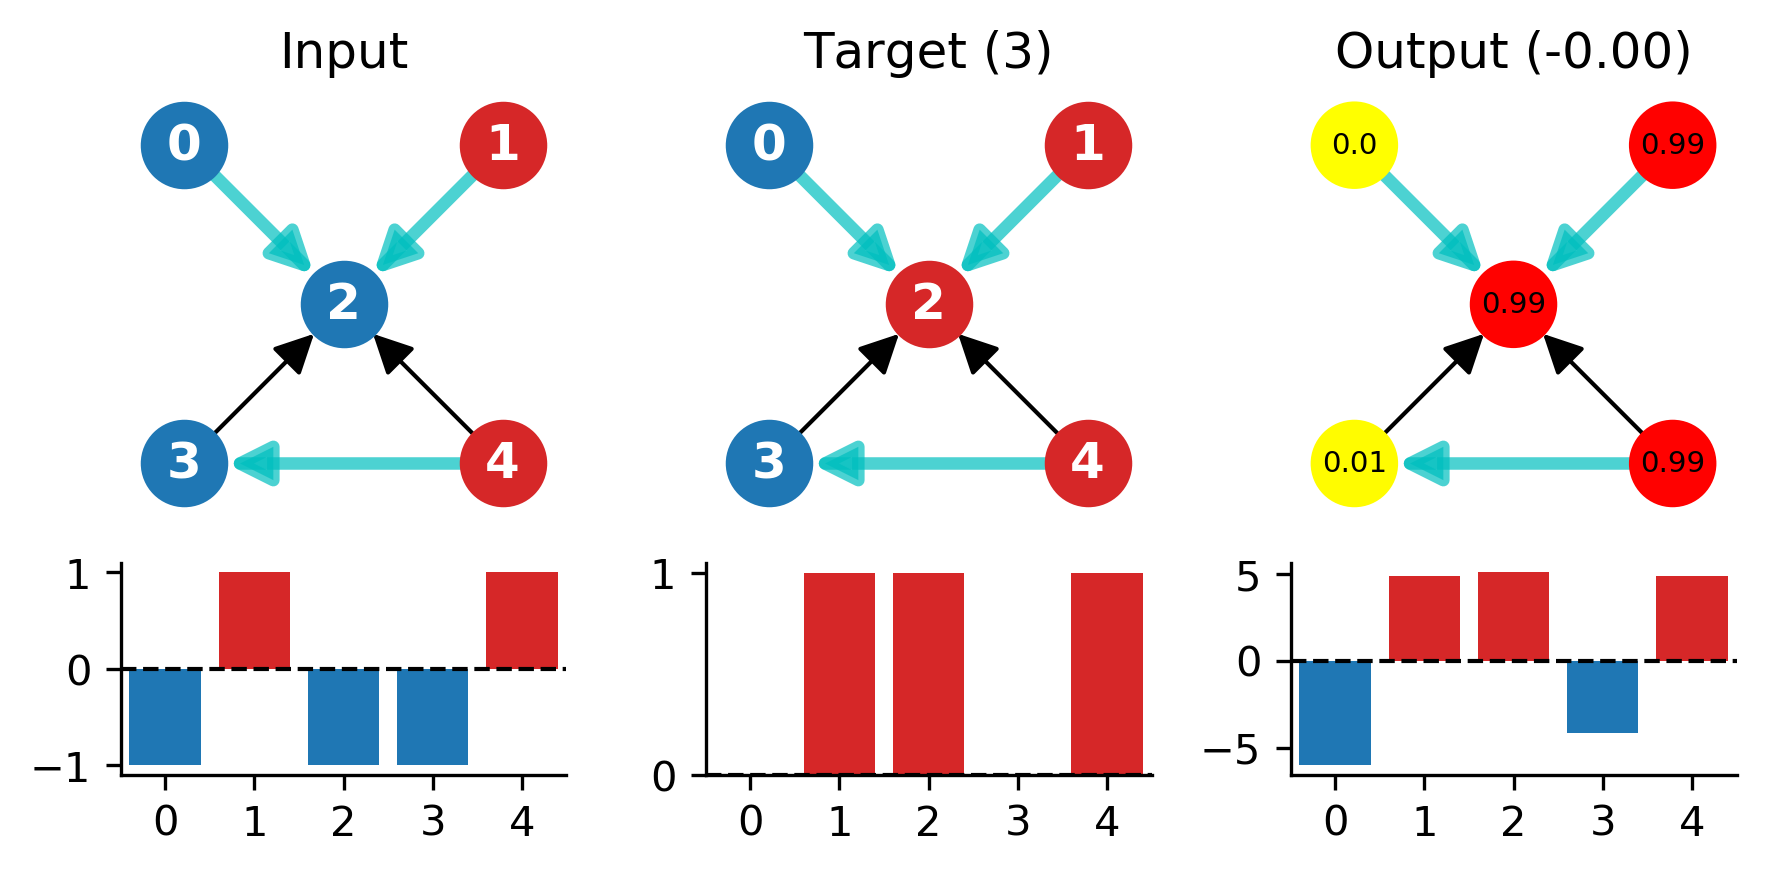

In [8]:
graph_out = net(tg.GraphBatch.collate([graph_in]))[0]
fig = plot_in_target_out(graph_in, graph_target, graph_out, layout)
fig.savefig(f'{name}-output.png', dpi=300, pad_inches=0)
display(fig)

#### Sensitivity
- Places the "blame" on node `2` itself, meaning _"If it was more sick it would be sick"_
- The real source of infection, node`4` receives a lower amount of sensitivity
- The non-virtual edge `4->2` is given negative sensitivity, meaning, _"If it was more virtual it would reduce the infection for `2`"_

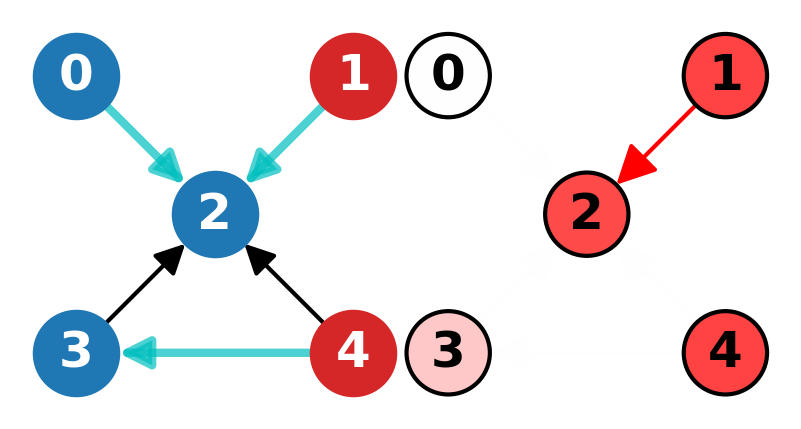

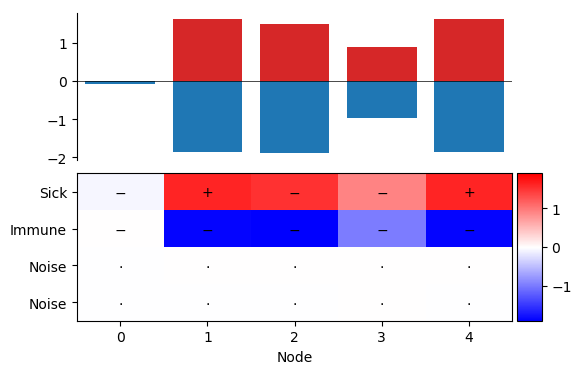

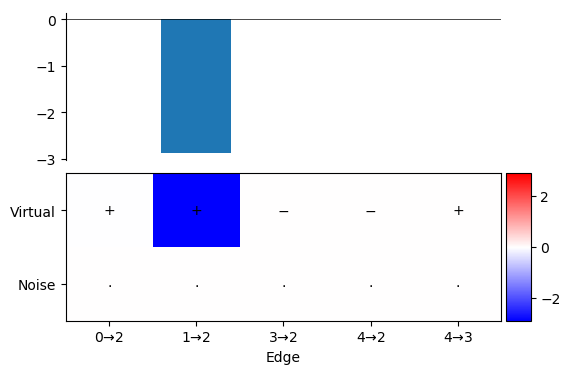

In [9]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
graph_out = net(batch)[0]

N = 2
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = 1

graph_in.zero_grad_()
graph_out.node_features.backward(node_relevance)

fig = plot_node_edge(graph_in.to_networkx(), batch, layout, squared=True)
fig.savefig(f'{name}-sa.png', dpi=300, pad_inches=0)
display(fig)

heat_n, heat_e = heatmaps(batch)
heat_n.savefig(f'{name}-sa-nodes.png', dpi=300, pad_inches=0)
heat_e.savefig(f'{name}-sa-edges.png', dpi=300, pad_inches=0)
display(heat_n)
display(heat_e)

#### Guided Backprop
- Seems like the source node and the infection edge are correctly identified
- But the importance for the edge is given to the uninformative feature

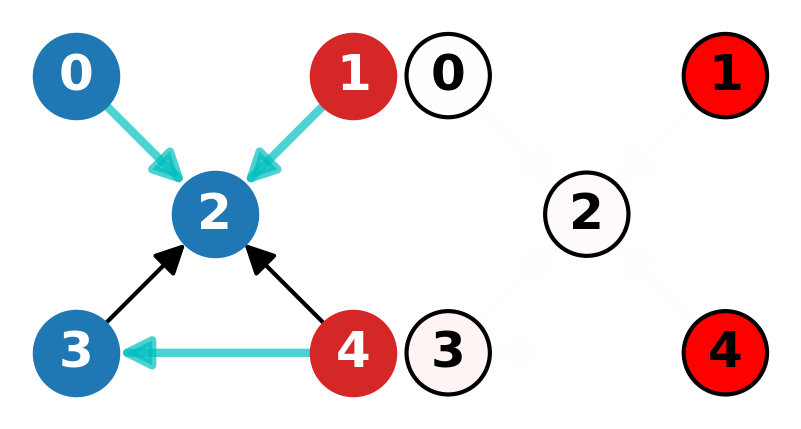

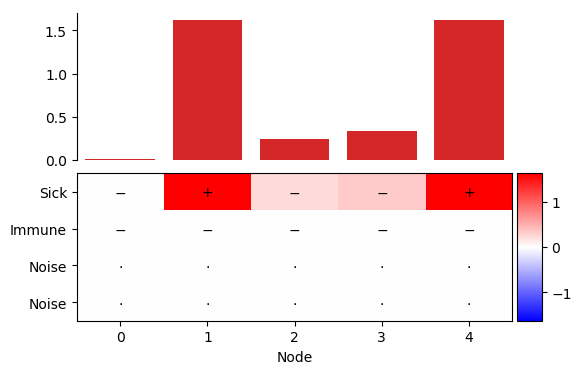

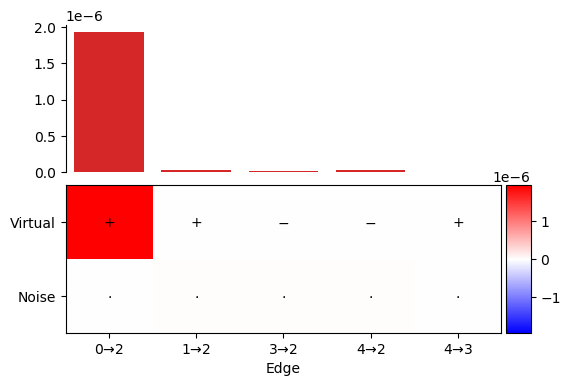

In [10]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
batch.node_features.register_hook(lambda grad: grad.clamp(min=0))
batch.edge_features.register_hook(lambda grad: grad.clamp(min=0))
graph_out = net_gp(batch)[0]

N = 2
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = 1

batch.zero_grad_()
graph_out.node_features.backward(node_relevance)

fig = plot_node_edge(graph_in.to_networkx(), batch, layout, squared=True)
fig.savefig(f'{name}-gbp.png', dpi=300, pad_inches=0)
display(fig)

heat_n, heat_e = heatmaps(batch)

heat_e.axes[0].yaxis.get_major_formatter().set_powerlimits((-3,4))
heat_e.axes[2].yaxis.get_major_formatter().set_powerlimits((-3,4))

heat_n.savefig(f'{name}-gbp-nodes.png', dpi=300, pad_inches=0)
heat_e.savefig(f'{name}-gbp-edges.png', dpi=300)
display(heat_n)
display(heat_e)

#### LRP

- Initial relevance is positive
- Positive relevance comes from the infected node `4` and the non-virtual edge `4->2`
- The fact that the neigbors `1` and `3` are not immune is also a source of small positive relevance
- Negative relevance comes from `2` itself because it's healthy
- Also, negative relevance comes from the virtual edge `0->2`

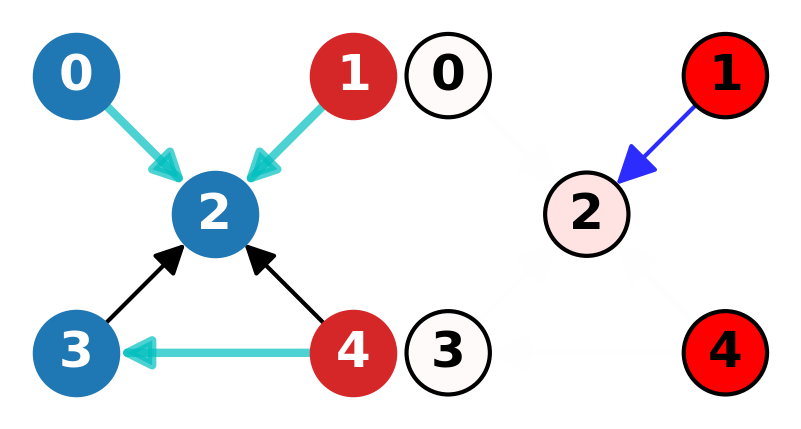

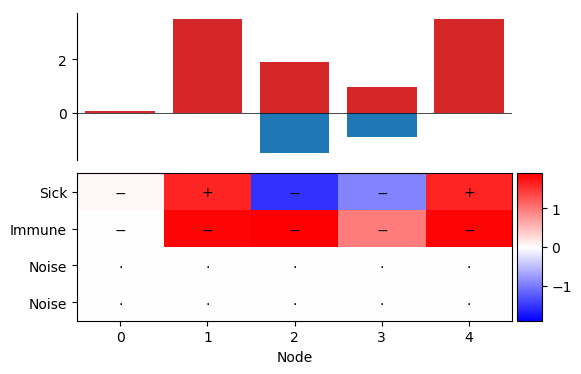

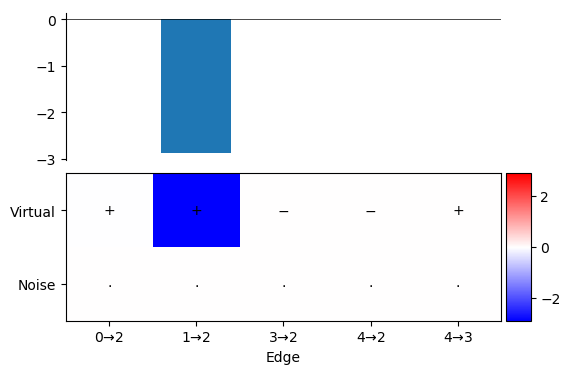

In [11]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
graph_out = net_lrp(batch)[0]

N = 2
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = graph_out.node_features[N]

graph_in.zero_grad_()
graph_out.node_features.backward(node_relevance)

fig = plot_node_edge(graph_in.to_networkx(), batch, layout, squared=False)
fig.savefig(f'{name}-lrp.png', dpi=300, pad_inches=0)
display(fig)

heat_n, heat_e = heatmaps(batch)
heat_n.savefig(f'{name}-lrp-nodes.png', dpi=300, pad_inches=0)
heat_e.savefig(f'{name}-lrp-edges.png', dpi=300, pad_inches=0)
display(heat_n)
display(heat_e)

## Simple graph 2 (2 possible infection sources)

In [12]:
graph_in = tg.Graph(
    node_features=torch.tensor([
        [-1, -1,  .45,  .23],
        [ 1, -1,  .52, -.12],
        [-1, -1, -.43,  .47],
        [-1,  1,  .78,  .96],
        [ 1, -1, -.82, -.28],
    ]),
    edge_features=torch.tensor([
        [-1, -.13],
        [-1,  .54],
        [-1, -.26],
        [-1,  .11],
        [+1,  .17],
    ]),
    senders=torch.tensor(  [0, 1, 2, 4, 4]),
    receivers=torch.tensor([2, 2, 3, 2, 3]),
)
graph_target = tg.Graph(
    node_features=torch.tensor([0, 1, 1, 0, 1]).view(-1, 1),
    global_features=torch.tensor([3])
)
name = 'graph-2'

#### Make a prediction with the loaded model

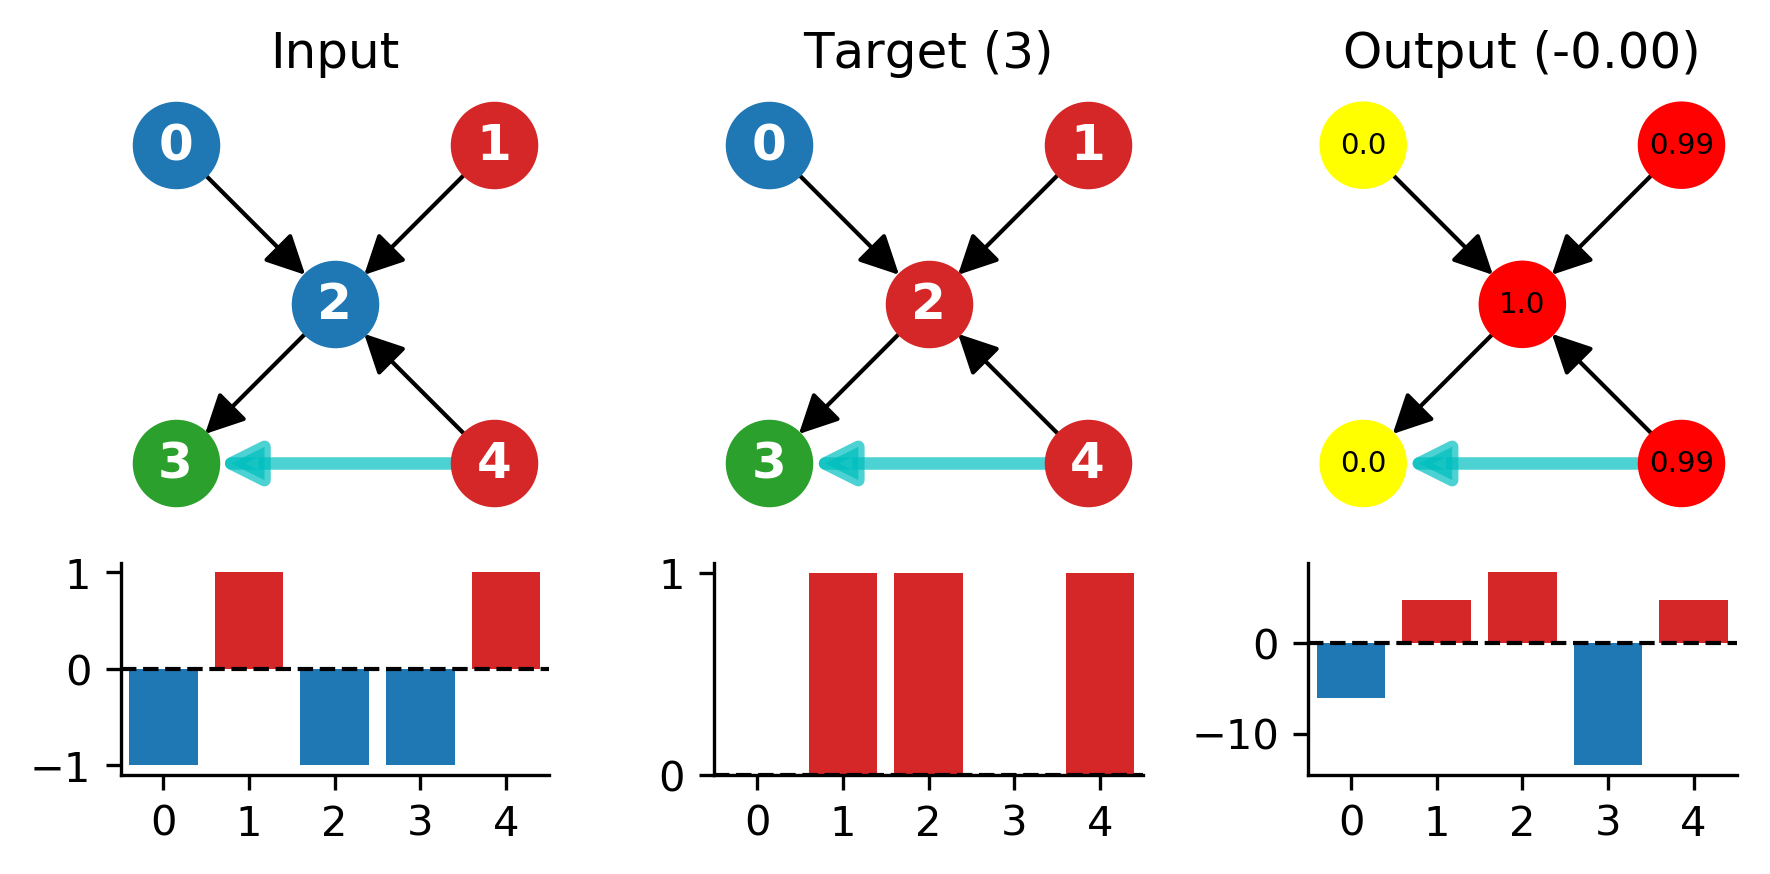

In [13]:
graph_out = net(tg.GraphBatch.collate([graph_in]))[0]
fig = plot_in_target_out(graph_in, graph_target, graph_out, layout)
fig.savefig(f'{name}-output.png', dpi=300, pad_inches=0)
display(fig)

#### Sensitivity
- Same problem of identifying the property of not being sick as the main factor to change in order to be infected

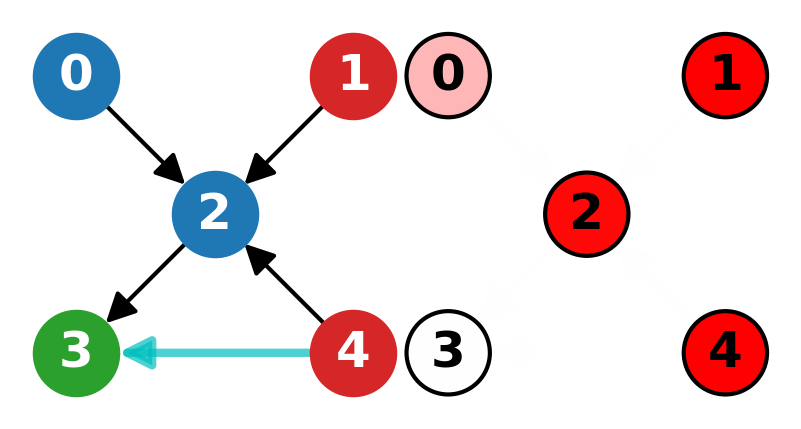

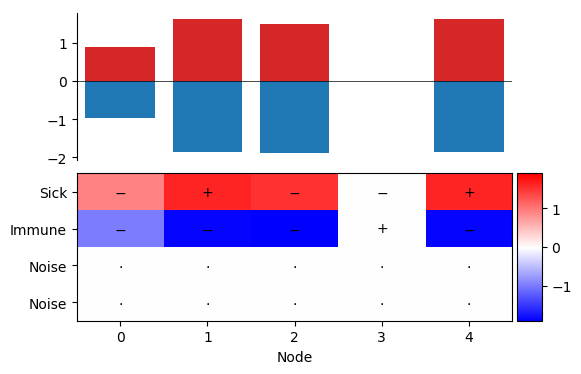

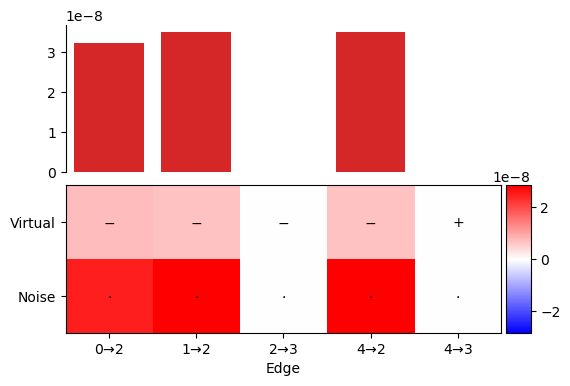

In [14]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
graph_out = net(batch)[0]

N = 2
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = 1

graph_in.zero_grad_()
graph_out.node_features.backward(node_relevance)

fig = plot_node_edge(graph_in.to_networkx(), batch, layout, squared=True)
fig.savefig(f'{name}-sa.png', dpi=300, pad_inches=0)
display(fig)

heat_n, heat_e = heatmaps(batch)
heat_n.savefig(f'{name}-sa-nodes.png', dpi=300, pad_inches=0)
heat_e.savefig(f'{name}-sa-edges.png', dpi=300, pad_inches=0)
display(heat_n)
display(heat_e)

#### Guided Backprop

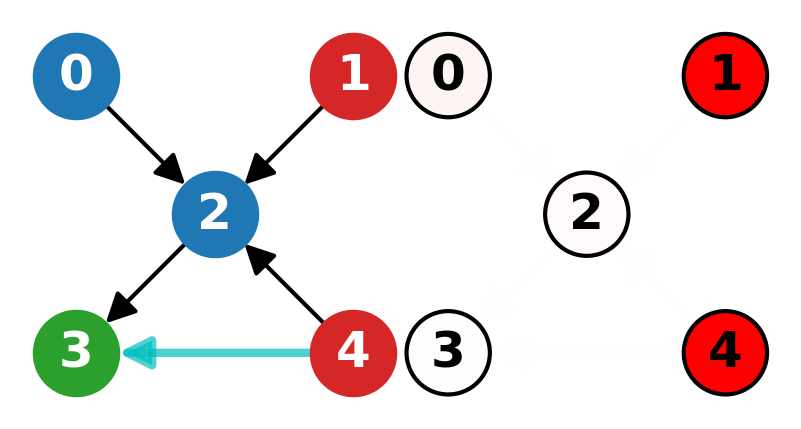

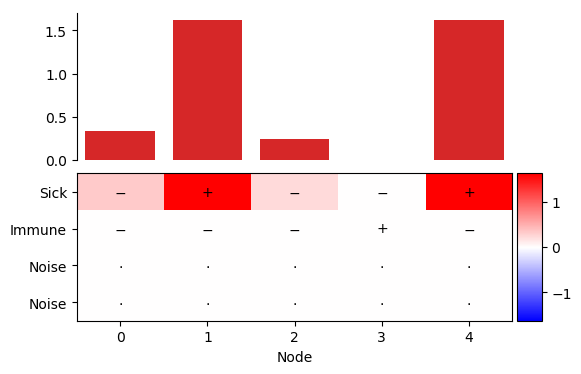

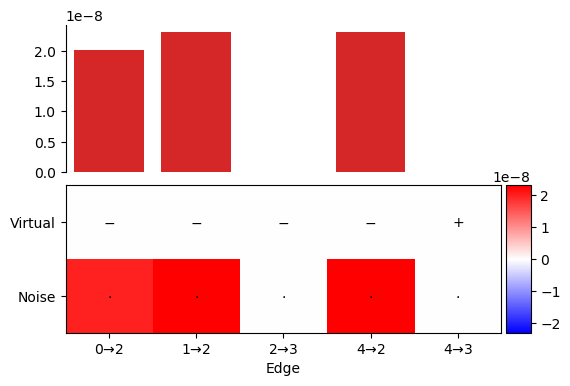

In [15]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
batch.node_features.register_hook(lambda grad: grad.clamp(min=0))
batch.edge_features.register_hook(lambda grad: grad.clamp(min=0))
graph_out = net_gp(batch)[0]

N = 2
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = 1

batch.zero_grad_()
graph_out.node_features.backward(node_relevance)

fig = plot_node_edge(graph_in.to_networkx(), batch, layout, squared=True)
fig.savefig(f'{name}-gbp.png', dpi=300, pad_inches=0)
display(fig)

heat_n, heat_e = heatmaps(batch)

heat_e.axes[0].yaxis.get_major_formatter().set_powerlimits((-3,4))
heat_e.axes[2].yaxis.get_major_formatter().set_powerlimits((-3,4))

heat_n.savefig(f'{name}-gbp-nodes.png', dpi=300, pad_inches=0)
heat_e.savefig(f'{name}-gbp-edges.png', dpi=300)
display(heat_n)
display(heat_e)

#### LRP

- Initial relevance is positive
- The node itself being healty speaks in favor of negative output
- Positive relevance comes from the infected node `4` and the non-virtual edge `4->2`
- Some positive relevance comes from the neighbor `0` which is healthy
- The virtual edge `0->2` brings negative relevance

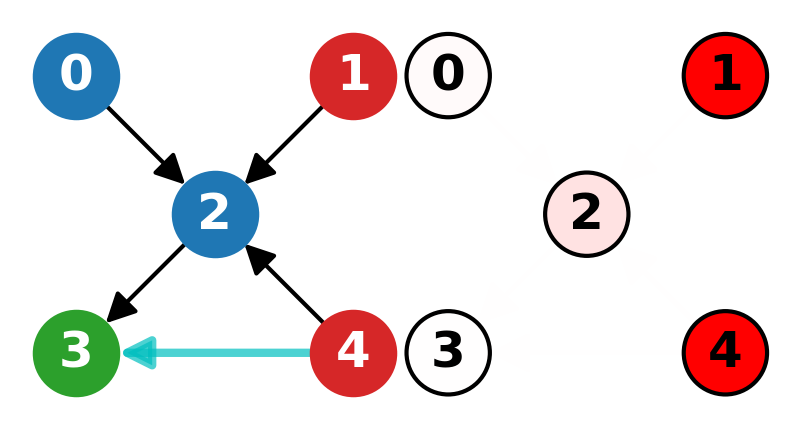

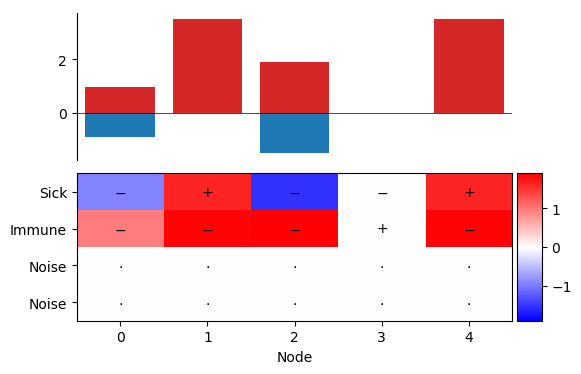

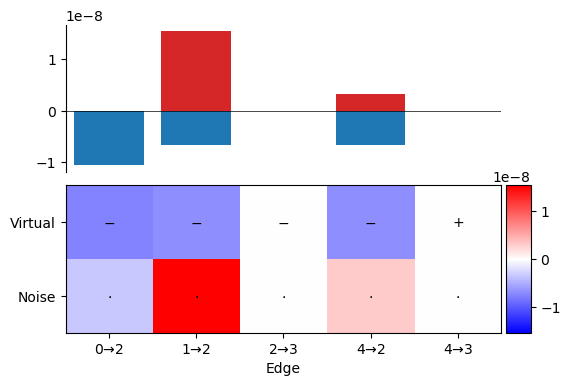

In [16]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
graph_out = net_lrp(batch)[0]

N = 2
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = graph_out.node_features[N]

graph_in.zero_grad_()
graph_out.node_features.backward(node_relevance)

fig = plot_node_edge(graph_in.to_networkx(), batch, layout, squared=False)
fig.savefig(f'{name}-lrp.png', dpi=300, pad_inches=0)
display(fig)

heat_n, heat_e = heatmaps(batch)
heat_n.savefig(f'{name}-lrp-nodes.png', dpi=300, pad_inches=0)
heat_e.savefig(f'{name}-lrp-edges.png', dpi=300, pad_inches=0)
display(heat_n)
display(heat_e)

## Simple graph 3 (All healthy)

In [17]:
graph_in = tg.Graph(
    node_features=torch.tensor([
        [-1, -1,  .45,  .23],
        [-1, -1,  .52, -.12],
        [-1, -1, -.43,  .47],
        [-1, -1,  .78,  .96],
        [-1, -1, -.82, -.28],
    ]),
    edge_features=torch.tensor([
        [-1, -.13],
        [+1,  .17],
        [-1,  .54],
        [-1, -.26],
        [-1, -.35],
    ]),
    senders=torch.tensor(  [0, 0, 1, 2, 4]),
    receivers=torch.tensor([2, 3, 2, 3, 2]),
)
graph_target = tg.Graph(
    node_features=torch.tensor([0, 0, 0, 0, 0]).view(-1, 1),
    global_features=torch.tensor([0])
)
name = 'graph-3'

#### Make a prediction with the loaded model

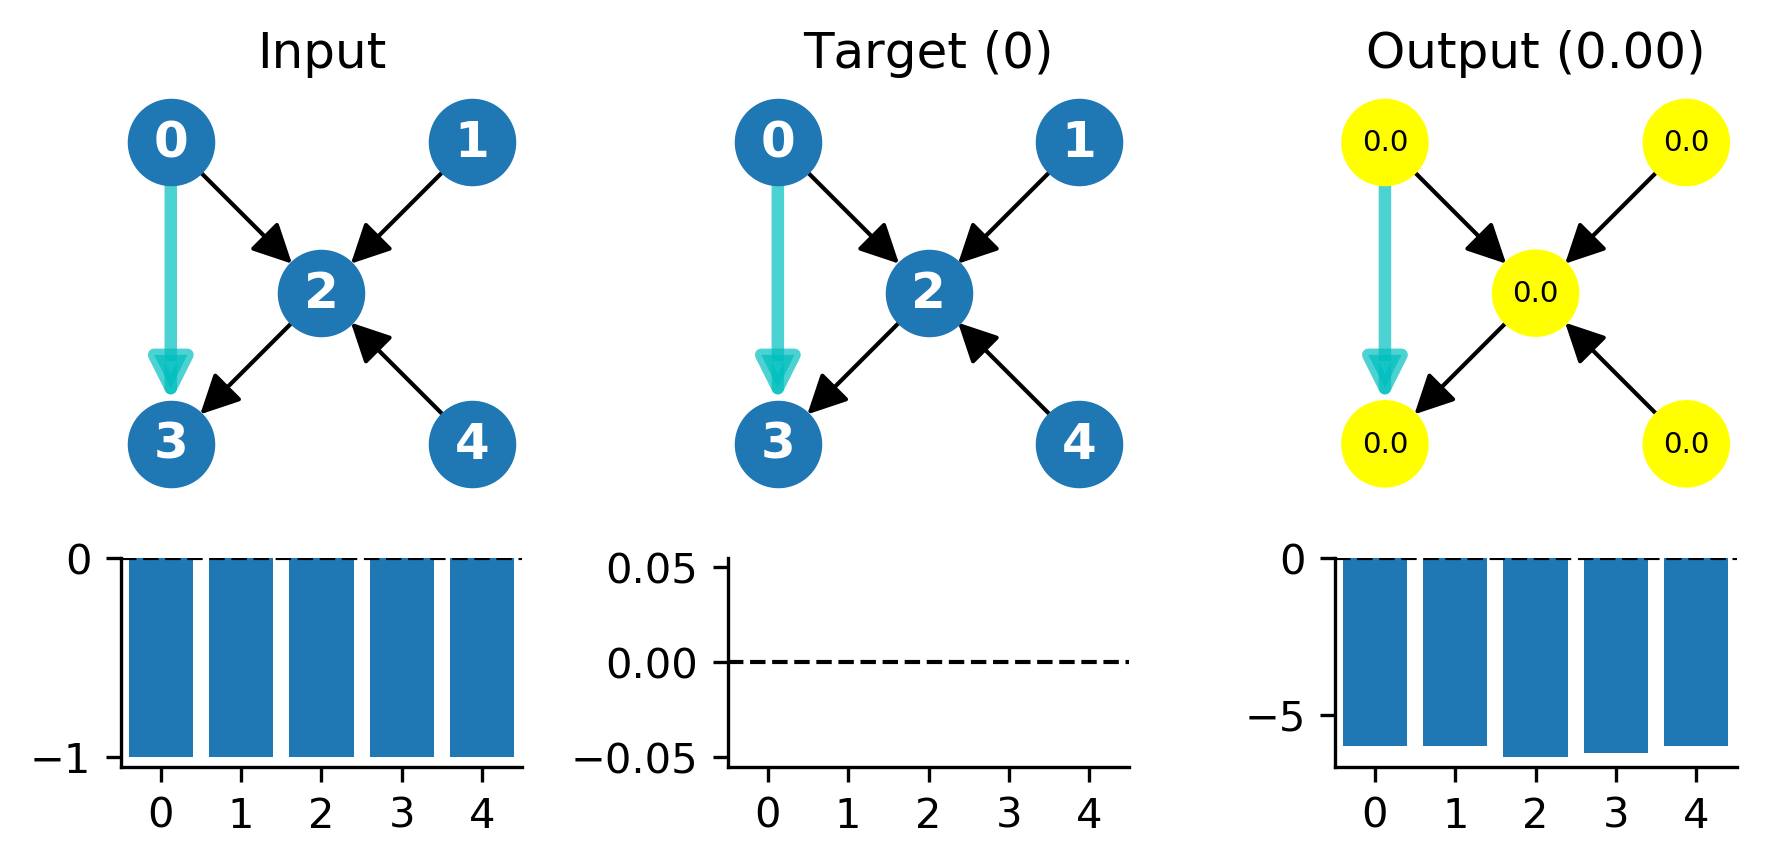

In [18]:
graph_out = net(tg.GraphBatch.collate([graph_in]))[0]
fig = plot_in_target_out(graph_in, graph_target, graph_out, layout)
fig.savefig(f'{name}-output.png', dpi=300, pad_inches=0)
display(fig)

#### Sensitivity

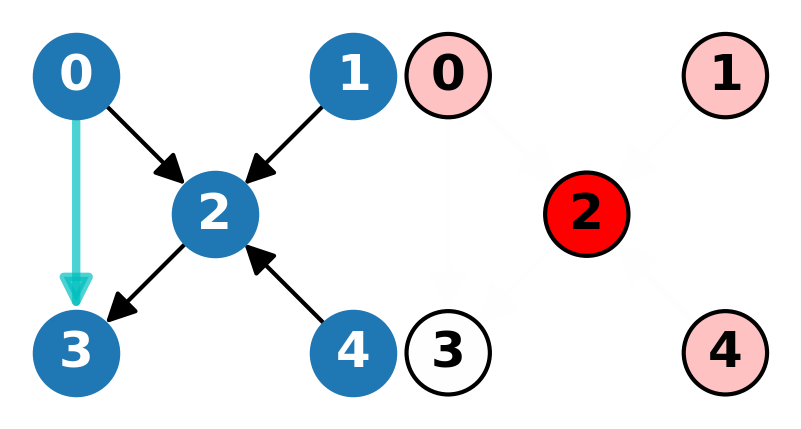

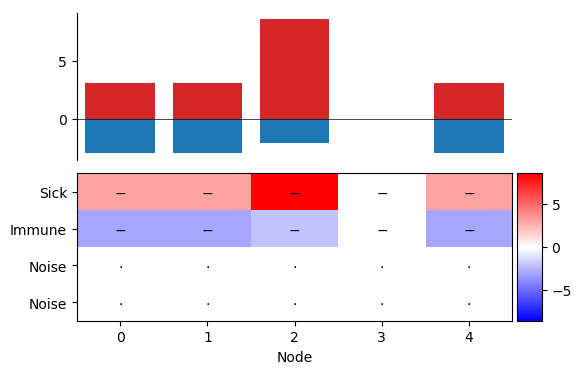

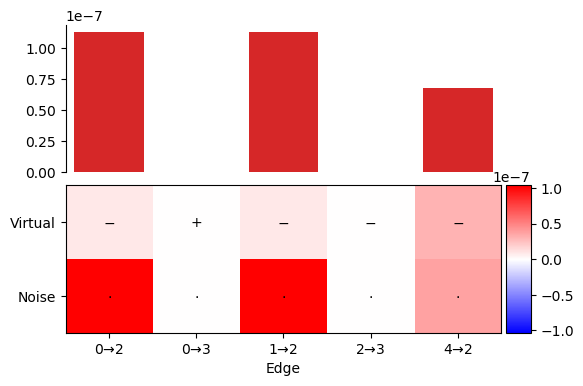

In [19]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
graph_out = net(batch)[0]

N = 2
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = 1

graph_in.zero_grad_()
graph_out.node_features.backward(node_relevance)

fig = plot_node_edge(graph_in.to_networkx(), batch, layout, squared=True)
fig.savefig(f'{name}-sa.png', dpi=300, pad_inches=0)
display(fig)

heat_n, heat_e = heatmaps(batch)
heat_n.savefig(f'{name}-sa-nodes.png', dpi=300, pad_inches=0)
heat_e.savefig(f'{name}-sa-edges.png', dpi=300, pad_inches=0)
display(heat_n)
display(heat_e)

#### Guided Backprop

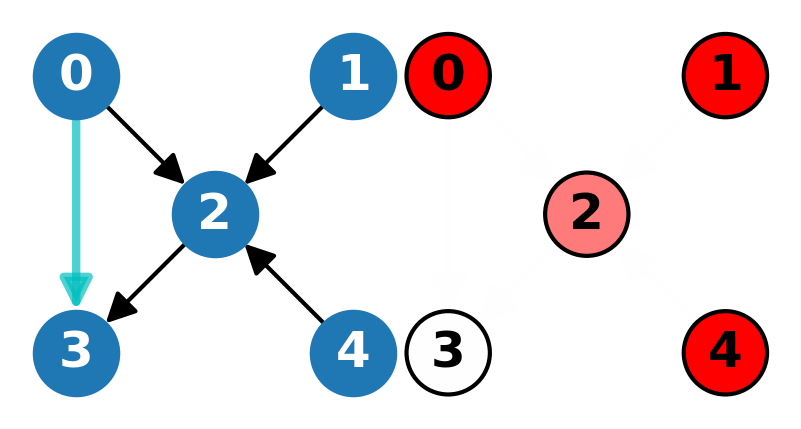

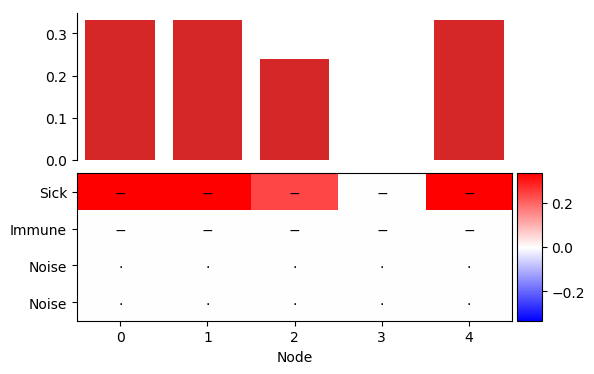

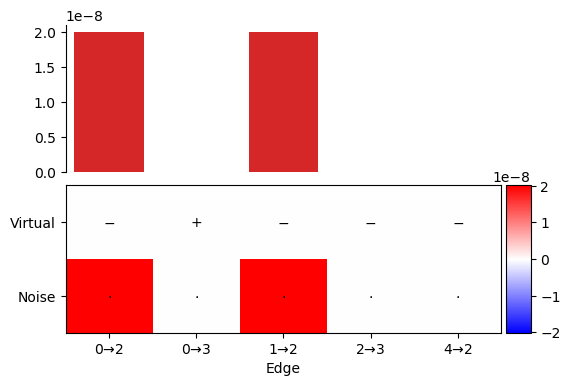

In [20]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
batch.node_features.register_hook(lambda grad: grad.clamp(min=0))
batch.edge_features.register_hook(lambda grad: grad.clamp(min=0))
graph_out = net_gp(batch)[0]

N = 2
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = 1

batch.zero_grad_()
graph_out.node_features.backward(node_relevance)

fig = plot_node_edge(graph_in.to_networkx(), batch, layout, squared=True)
fig.savefig(f'{name}-gbp.png', dpi=300, pad_inches=0)
display(fig)

heat_n, heat_e = heatmaps(batch)
heat_n.savefig(f'{name}-gbp-nodes.png', dpi=300, pad_inches=0)
heat_e.savefig(f'{name}-gbp-edges.png', dpi=300, pad_inches=0)
display(heat_n)
display(heat_e)

#### LRP

- Initial relevance is negative
- Most of the negative relevance comes from the fact that node `2` is healty

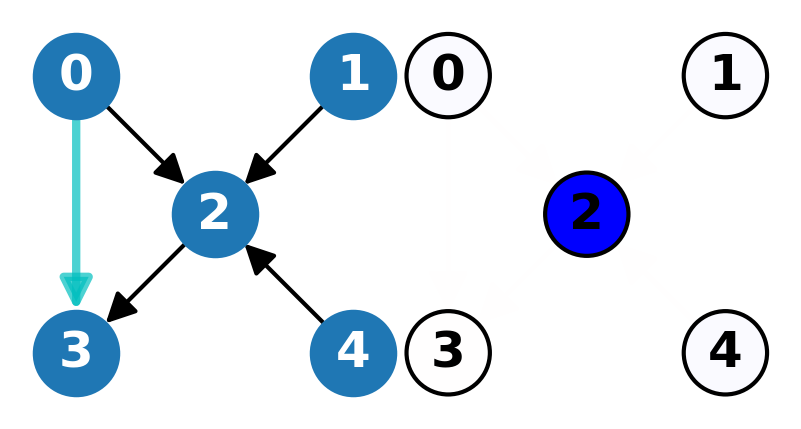

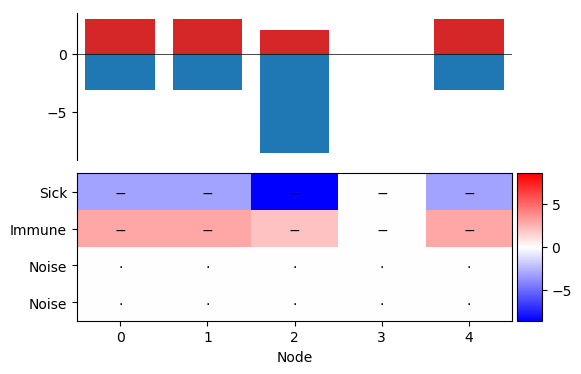

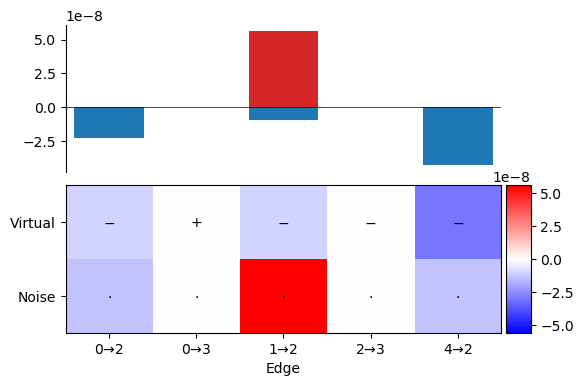

In [21]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
graph_out = net_lrp(batch)[0]

N = 2
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = graph_out.node_features[N]

graph_in.zero_grad_()
graph_out.node_features.backward(node_relevance)

fig = plot_node_edge(graph_in.to_networkx(), batch, layout, squared=False)
fig.savefig(f'{name}-lrp.png', dpi=300, pad_inches=0)
display(fig)

heat_n, heat_e = heatmaps(batch)
heat_n.savefig(f'{name}-lrp-nodes.png', dpi=300, pad_inches=0)
heat_e.savefig(f'{name}-lrp-edges.png', dpi=300, pad_inches=0)
display(heat_n)
display(heat_e)

## Simple graph 4 (1 healhty surrounderd by 4 sick)

In [22]:
graph_in = tg.Graph(
    node_features=torch.tensor([
        [ 1, -1,  .45,  .23],
        [ 1, -1,  .52, -.12],
        [-1, -1, -.43,  .47],
        [ 1, -1,  .78,  .96],
        [ 1, -1, -.82, -.28],
    ]),
    edge_features=torch.tensor([
        [-1, -.13],
        [+1,  .17],
        [-1,  .54],
        [-1, -.26],
        [-1, -.35],
    ]),
    senders=torch.tensor(  [0, 0, 1, 3, 4]),
    receivers=torch.tensor([2, 1, 2, 2, 2]),
)
graph_target = tg.Graph(
    node_features=torch.tensor([1, 1, 1, 1, 1]).view(-1, 1),
    global_features=torch.tensor([5])
)
name = 'graph-4'

#### Make a prediction with the loaded model

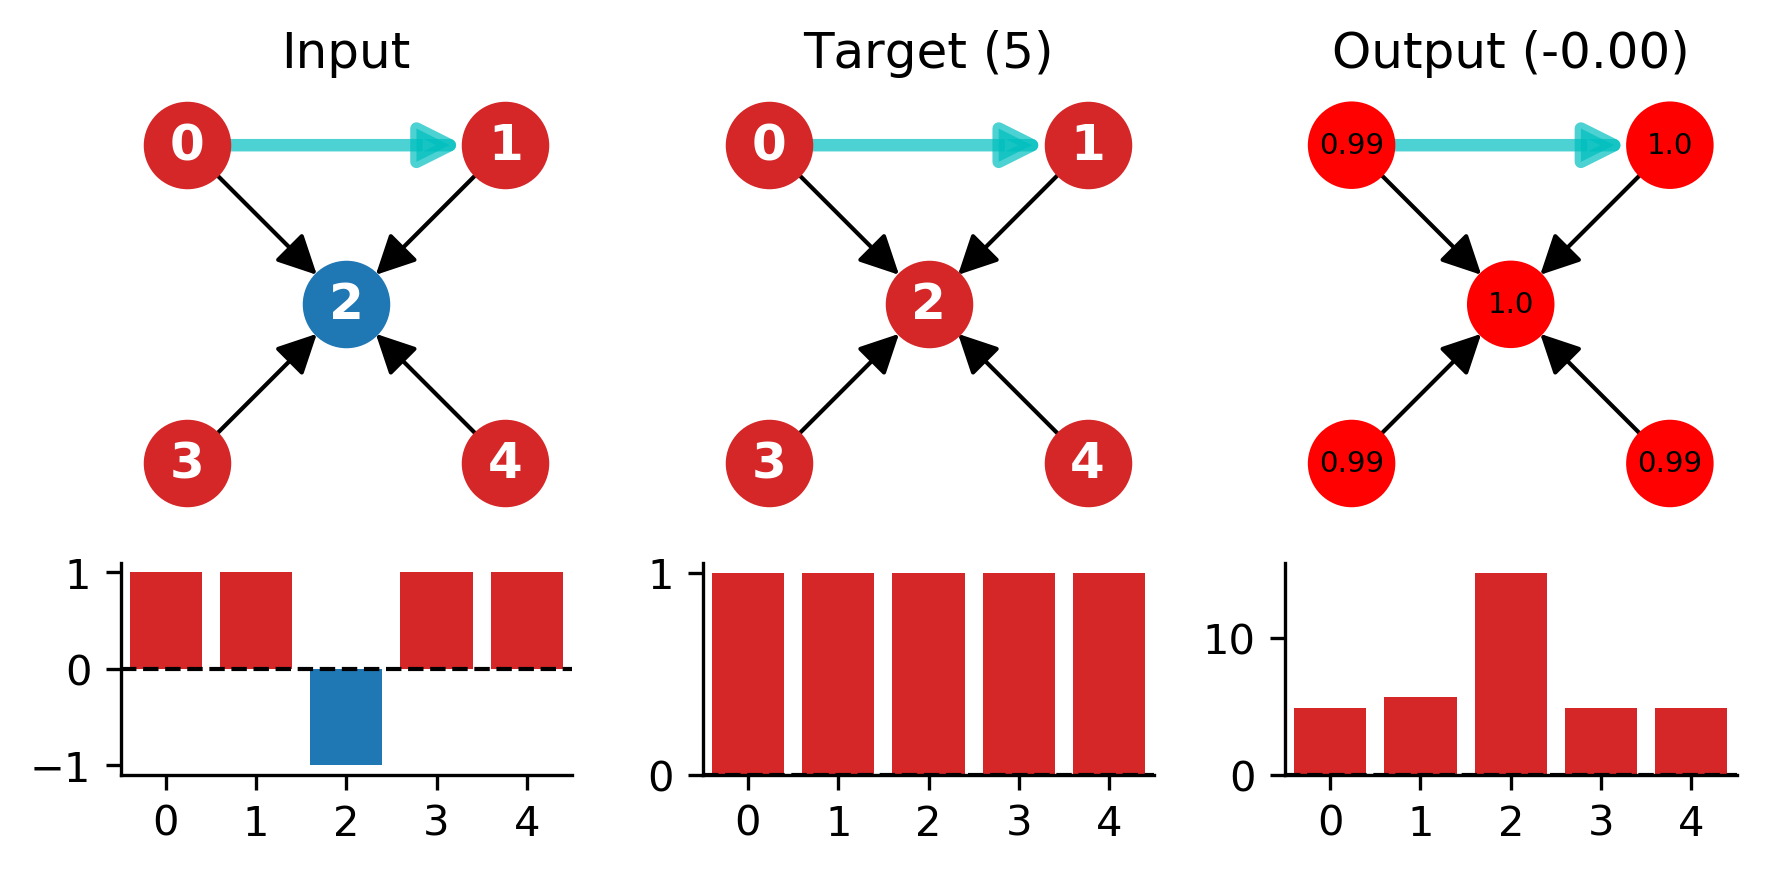

In [23]:
graph_out = net(tg.GraphBatch.collate([graph_in]))[0]
fig = plot_in_target_out(graph_in, graph_target, graph_out, layout)
fig.savefig(f'{name}-output.png', dpi=300, pad_inches=0)
display(fig)

#### Sensitivity

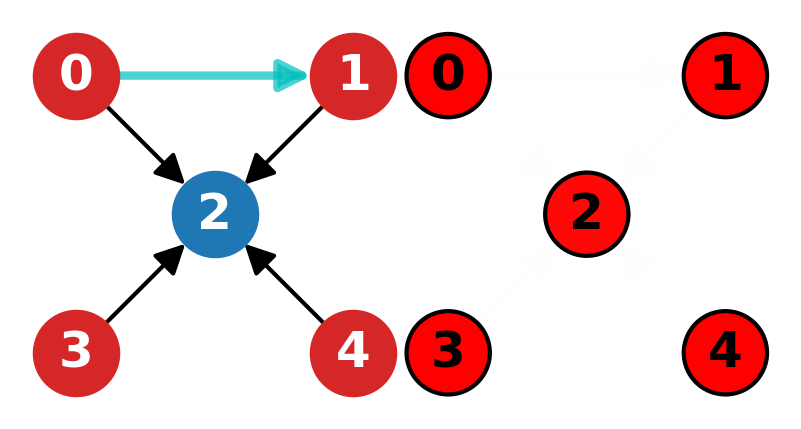

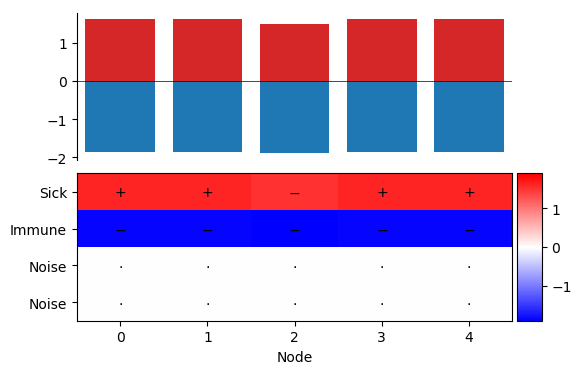

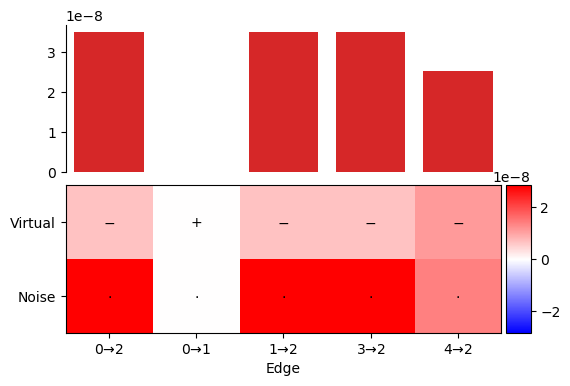

In [24]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
graph_out = net(batch)[0]

N = 2
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = 1

graph_in.zero_grad_()
graph_out.node_features.backward(node_relevance)

fig = plot_node_edge(graph_in.to_networkx(), batch, layout, squared=True)
fig.savefig(f'{name}-sa.png', dpi=300, pad_inches=0)
display(fig)

heat_n, heat_e = heatmaps(batch)
heat_n.savefig(f'{name}-sa-nodes.png', dpi=300, pad_inches=0)
heat_e.savefig(f'{name}-sa-edges.png', dpi=300, pad_inches=0)
display(heat_n)
display(heat_e)

#### Guided Backprop
- Seems like the source node and the infection edge are correctly identified
- But the importance for the edge is given to the uninformative feature

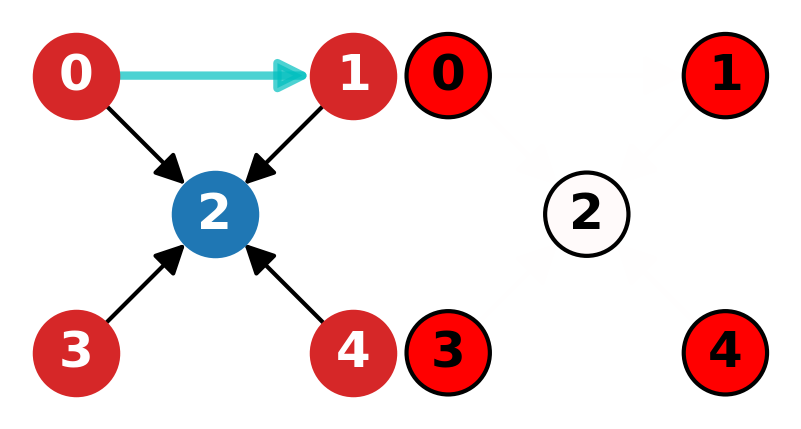

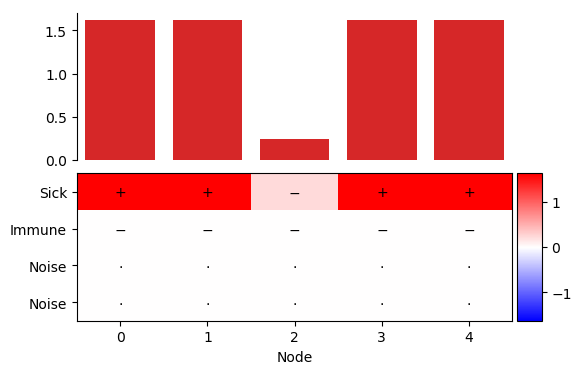

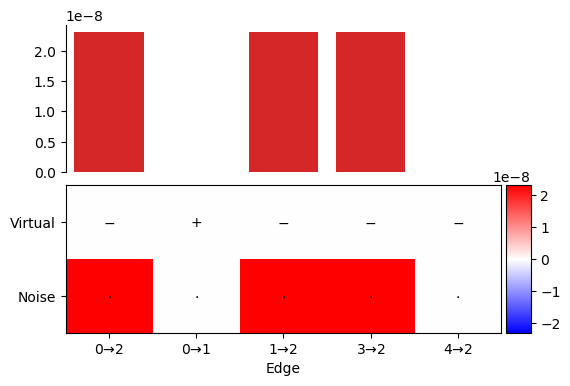

In [25]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
batch.node_features.register_hook(lambda grad: grad.clamp(min=0))
batch.edge_features.register_hook(lambda grad: grad.clamp(min=0))
graph_out = net_gp(batch)[0]

N = 2
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = 1

batch.zero_grad_()
graph_out.node_features.backward(node_relevance)

fig = plot_node_edge(graph_in.to_networkx(), batch, layout, squared=True)
fig.savefig(f'{name}-gbp.png', dpi=300, pad_inches=0)
display(fig)

heat_n, heat_e = heatmaps(batch)

heat_e.axes[0].yaxis.get_major_formatter().set_powerlimits((-3,4))
heat_e.axes[2].yaxis.get_major_formatter().set_powerlimits((-3,4))

heat_n.savefig(f'{name}-gbp-nodes.png', dpi=300, pad_inches=0)
heat_e.savefig(f'{name}-gbp-edges.png', dpi=300)
display(heat_n)
display(heat_e)

#### LRP

- Initial relevance is positive
- Positive relevance comes from the infected node `4` and the non-virtual edge `4->2`
- The fact that the neigbors `1` and `3` are not immune is also a source of small positive relevance
- Negative relevance comes from `2` itself because it's healthy
- Also, negative relevance comes from the virtual edge `0->2`

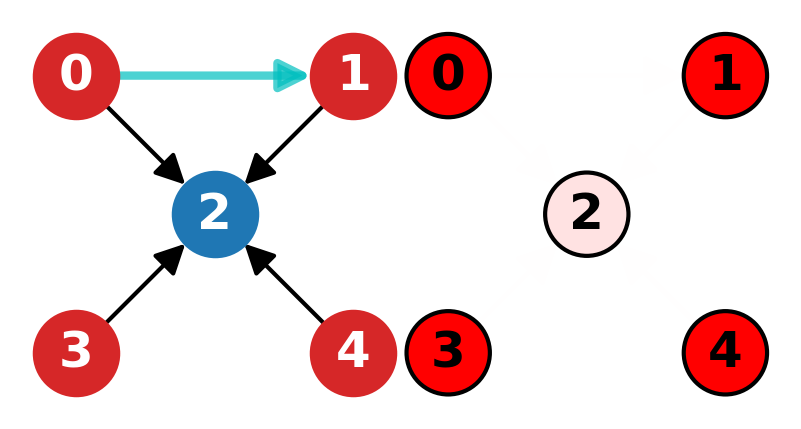

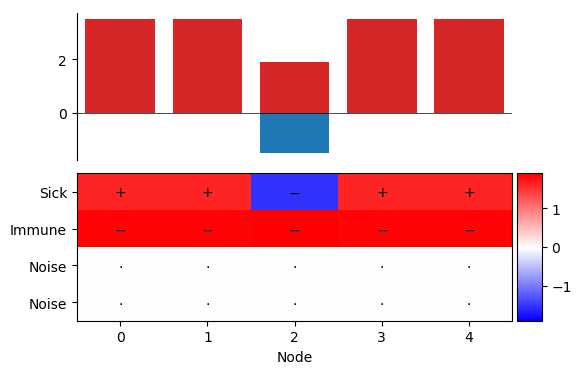

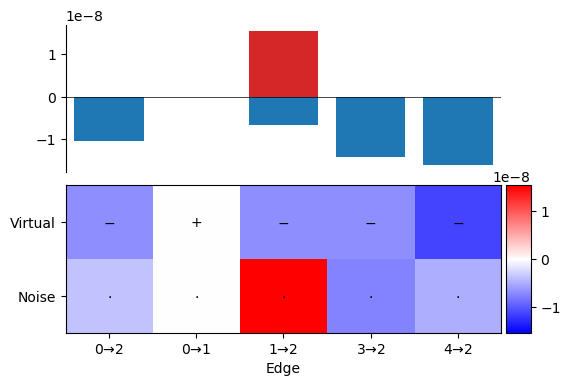

In [26]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
graph_out = net_lrp(batch)[0]

N = 2
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = graph_out.node_features[N]

graph_in.zero_grad_()
graph_out.node_features.backward(node_relevance)

fig = plot_node_edge(graph_in.to_networkx(), batch, layout, squared=False)
fig.savefig(f'{name}-lrp.png', dpi=300, pad_inches=0)
display(fig)

heat_n, heat_e = heatmaps(batch)
heat_n.savefig(f'{name}-lrp-nodes.png', dpi=300, pad_inches=0)
heat_e.savefig(f'{name}-lrp-edges.png', dpi=300, pad_inches=0)
display(heat_n)
display(heat_e)

## Simple graph 5 (1 immune surrounded by 4 sick)

In [27]:
graph_in = tg.Graph(
    node_features=torch.tensor([
        [ 1, -1,  .45,  .23],
        [ 1, -1,  .52, -.12],
        [-1,  1, -.43,  .47],
        [ 1, -1,  .78,  .96],
        [ 1, -1, -.82, -.28],
    ]),
    edge_features=torch.tensor([
        [-1, -.13],
        [+1,  .17],
        [-1,  .54],
        [-1, -.26],
        [-1, -.35],
    ]),
    senders=torch.tensor(  [0, 0, 1, 3, 4]),
    receivers=torch.tensor([2, 1, 2, 2, 2]),
)
graph_target = tg.Graph(
    node_features=torch.tensor([1, 1, 1, 1, 1]).view(-1, 1),
    global_features=torch.tensor([4])
)
name = 'graph-5'

#### Make a prediction with the loaded model

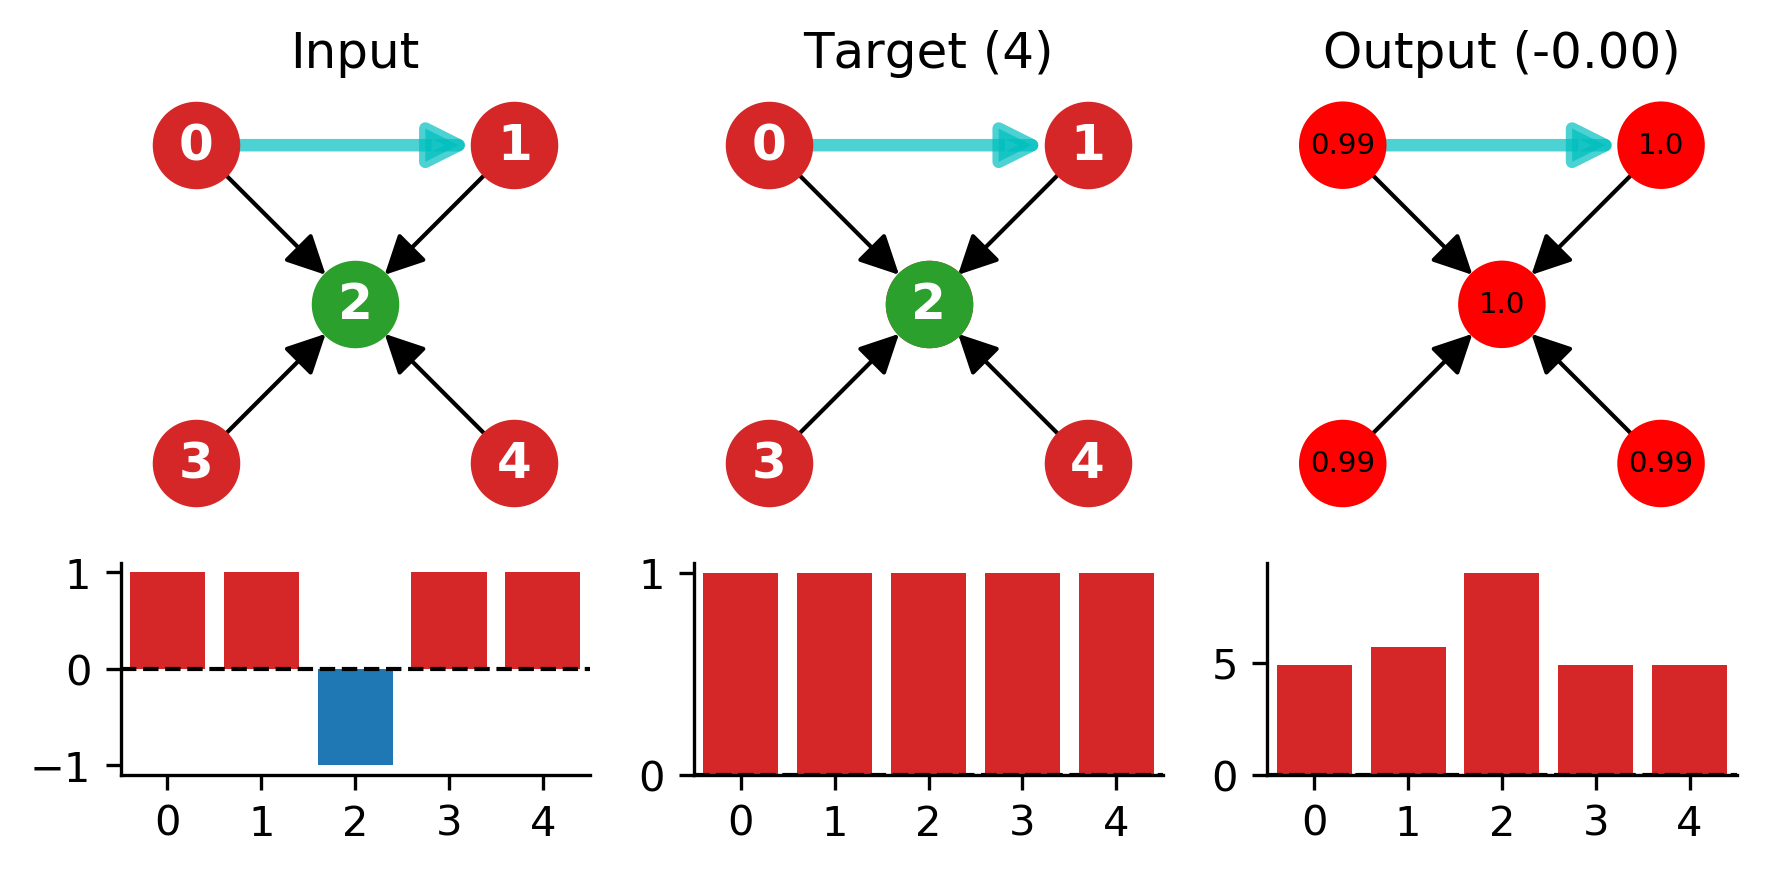

In [28]:
graph_out = net(tg.GraphBatch.collate([graph_in]))[0]
fig = plot_in_target_out(graph_in, graph_target, graph_out, layout)
fig.savefig(f'{name}-output.png', dpi=300, pad_inches=0)
display(fig)

#### Sensitivity

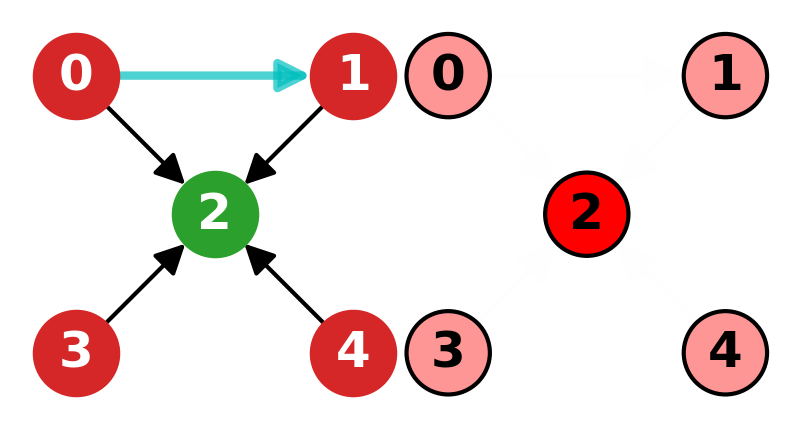

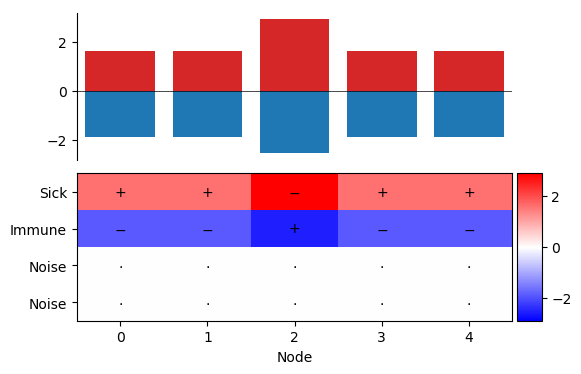

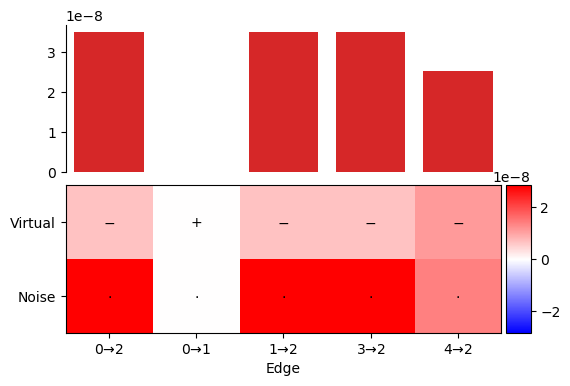

In [29]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
graph_out = net(batch)[0]

N = 2
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = 1

graph_in.zero_grad_()
graph_out.node_features.backward(node_relevance)

fig = plot_node_edge(graph_in.to_networkx(), batch, layout, squared=True)
fig.savefig(f'{name}-sa.png', dpi=300, pad_inches=0)
display(fig)

heat_n, heat_e = heatmaps(batch)
heat_n.savefig(f'{name}-sa-nodes.png', dpi=300, pad_inches=0)
heat_e.savefig(f'{name}-sa-edges.png', dpi=300, pad_inches=0)
display(heat_n)
display(heat_e)

#### Guided Backprop
- Seems like the source node and the infection edge are correctly identified
- But the importance for the edge is given to the uninformative feature

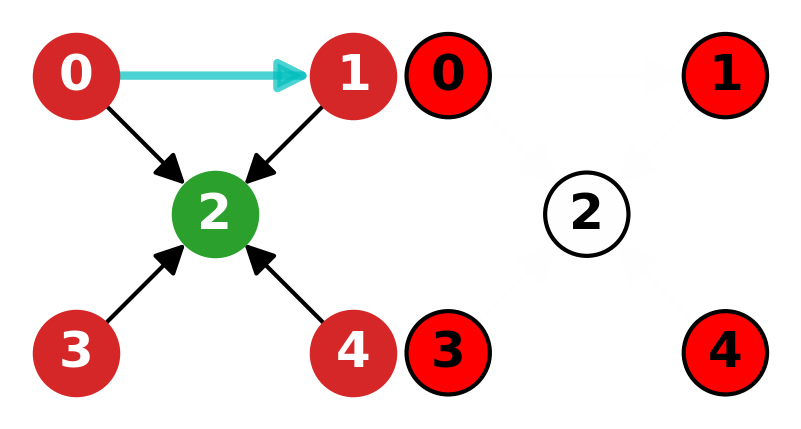

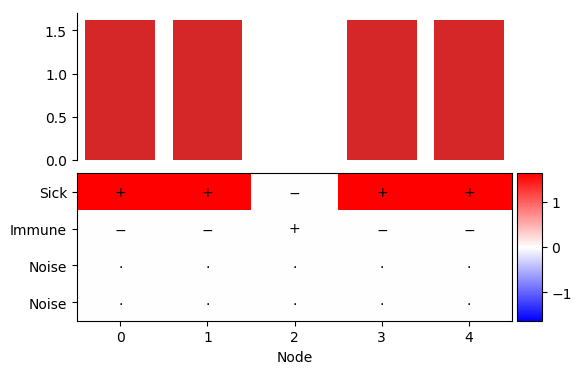

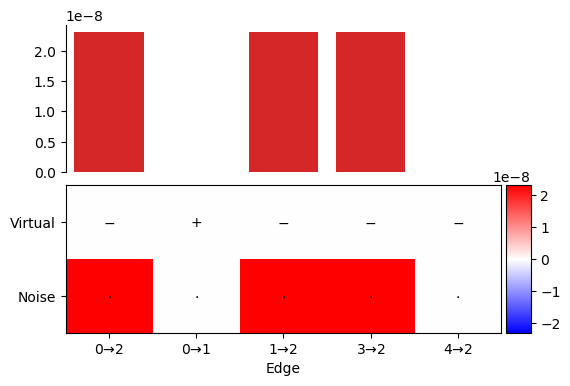

In [30]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
batch.node_features.register_hook(lambda grad: grad.clamp(min=0))
batch.edge_features.register_hook(lambda grad: grad.clamp(min=0))
graph_out = net_gp(batch)[0]

N = 2
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = 1

batch.zero_grad_()
graph_out.node_features.backward(node_relevance)

fig = plot_node_edge(graph_in.to_networkx(), batch, layout, squared=True)
fig.savefig(f'{name}-gbp.png', dpi=300, pad_inches=0)
display(fig)

heat_n, heat_e = heatmaps(batch)

heat_e.axes[0].yaxis.get_major_formatter().set_powerlimits((-3,4))
heat_e.axes[2].yaxis.get_major_formatter().set_powerlimits((-3,4))

heat_n.savefig(f'{name}-gbp-nodes.png', dpi=300, pad_inches=0)
heat_e.savefig(f'{name}-gbp-edges.png', dpi=300)
display(heat_n)
display(heat_e)

#### LRP

- Initial relevance is positive
- Positive relevance comes from the infected node `4` and the non-virtual edge `4->2`
- The fact that the neigbors `1` and `3` are not immune is also a source of small positive relevance
- Negative relevance comes from `2` itself because it's healthy
- Also, negative relevance comes from the virtual edge `0->2`

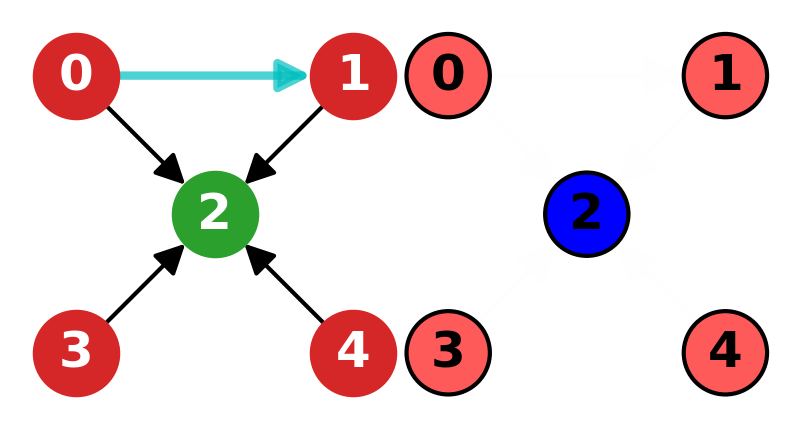

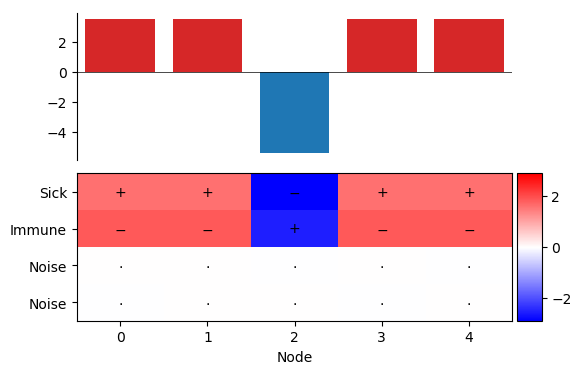

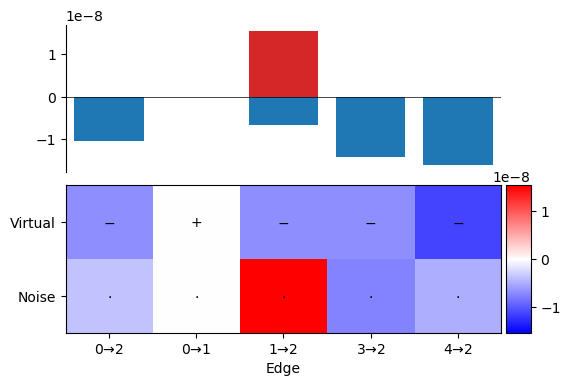

In [31]:
batch = tg.GraphBatch.collate([graph_in]).requires_grad_()
graph_out = net_lrp(batch)[0]

N = 2
node_relevance = torch.zeros_like(graph_out.node_features)
node_relevance[N] = graph_out.node_features[N]

graph_in.zero_grad_()
graph_out.node_features.backward(node_relevance)

fig = plot_node_edge(graph_in.to_networkx(), batch, layout, squared=False)
fig.savefig(f'{name}-lrp.png', dpi=300, pad_inches=0)
display(fig)

heat_n, heat_e = heatmaps(batch)
heat_n.savefig(f'{name}-lrp-nodes.png', dpi=300, pad_inches=0)
heat_e.savefig(f'{name}-lrp-edges.png', dpi=300, pad_inches=0)
display(heat_n)
display(heat_e)